## Problem #1
### Kaggle - House Prices: Advanced Regression Techniques 

After installing the API to download data from Kaggle

In [1]:
%cd ~/.kaggle/competitions/house-prices-advanced-regression-techniques

/Users/rachit/.kaggle/competitions/house-prices-advanced-regression-techniques


In [3]:
%ls

data_description.txt      submission.csv            train.csv
sample_submission.csv     test.csv                  train.csv.gz
sample_submission.csv.gz  test.csv.gz


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [4]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
train_ID = train_df['Id']
test_ID = test_df['Id']

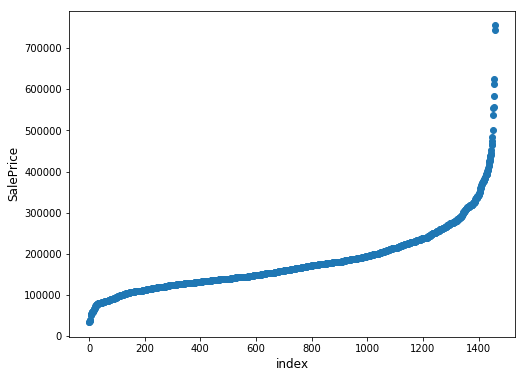

In [6]:
# plotting the dependant variable

plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df.SalePrice.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('SalePrice', fontsize=12)
plt.show()

### Dependant Variable Analysis

In [8]:
from scipy import stats
from scipy.stats import norm, skew #for some statistics


 mu = 180921.20 and sigma = 79415.29



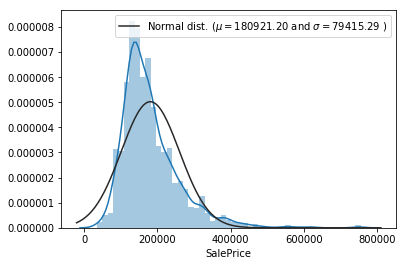

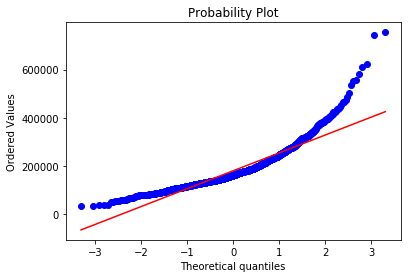

In [9]:
sns.distplot(train_df['SalePrice'], fit=norm);

(mu, sigma) = norm.fit(train_df['SalePrice'])
print ('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))


# plot the distribution
plt.legend(['Normal dist. ($\mu=${:.2f} and $\sigma=${:.2f} )'.format(mu,sigma)])

# also creating the Q-Q plot

fig=plt.figure()
res = stats.probplot(train_df['SalePrice'], plot=plt)
plt.show()

Dependant variable has right skew, and since linear models require normoal distribution, will apply transformation in the next step

#### Log transformation of the dependant variable

In [10]:
# using numpy's log1p, which is log(1+x) on the column

train_df["ln_SalePrice"] = np.log1p(train_df["SalePrice"])

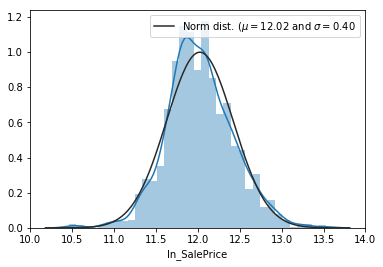

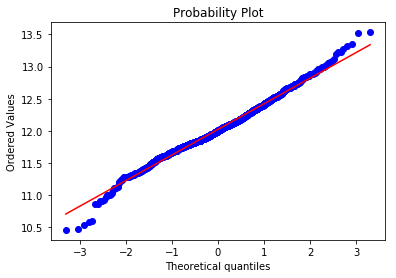

In [11]:
# checking the new distribution
(mu, sigma) = norm.fit(train_df['ln_SalePrice'])
sns.distplot(train_df['ln_SalePrice'], fit=norm)

plt.legend([('Norm dist. ($\mu=${:.2f} and $\sigma=${:.2f}').format(mu, sigma)])

fig = plt.figure()
res = stats.probplot(train_df['ln_SalePrice'], plot=plt)
plt.show()



In [12]:
ntrain = train_df.shape[0]
ntest = test_df.shape[0]

y_train = train_df.ln_SalePrice.values
all_data = pd.concat((train_df, test_df)).reset_index(drop=True)

all_data.drop(['SalePrice', 'ln_SalePrice'], axis=1, inplace=True)

In [13]:
all_data.shape, train_df.shape, test_df.shape

((2919, 80), (1460, 82), (1459, 80))

In [16]:
train_df['SalePrice'].head(), np.log1p(train_df["SalePrice"].head()), train_df['ln_SalePrice'].head()

(0    208500
 1    181500
 2    223500
 3    140000
 4    250000
 Name: SalePrice, dtype: int64, 0    12.247699
 1    12.109016
 2    12.317171
 3    11.849405
 4    12.429220
 Name: SalePrice, dtype: float64, 0    12.247699
 1    12.109016
 2    12.317171
 3    11.849405
 4    12.429220
 Name: ln_SalePrice, dtype: float64)

In [14]:
all_data['garage_decade'] = (all_data.GarageYrBlt//10)*10

#### Fill Rate Analysis

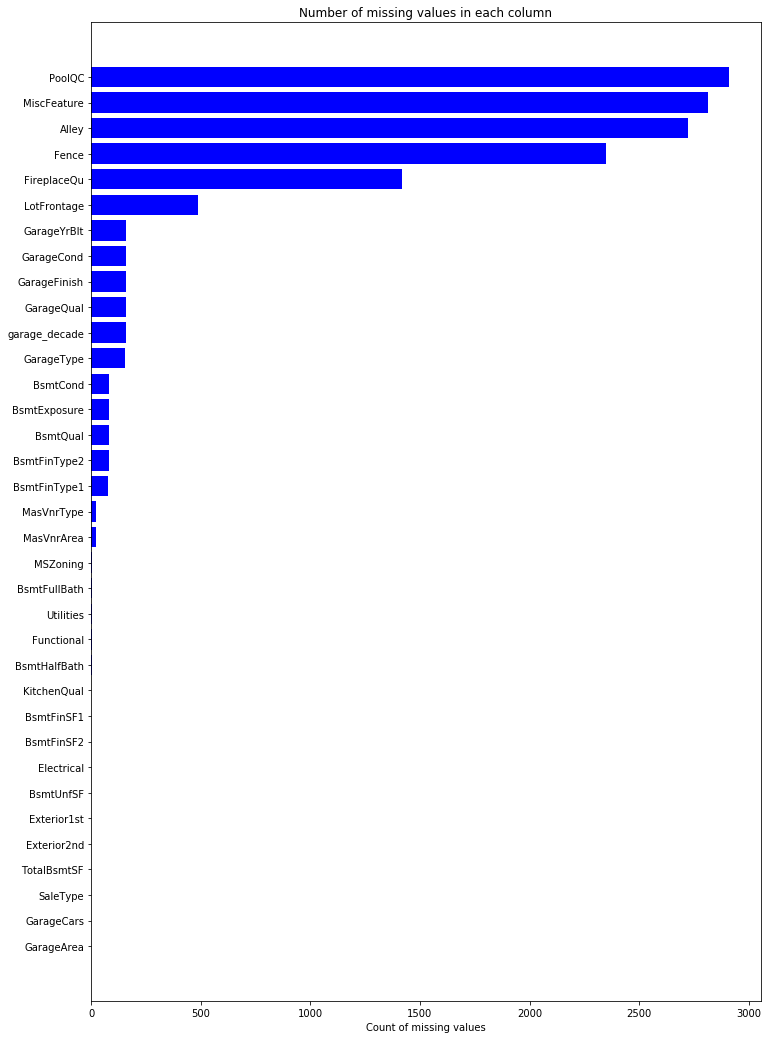

In [15]:
missing_df = all_data.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()


In [18]:
# Can drop the below variables since there is more than 80% missing data

missing_df = all_data.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['missing_ratio'] = missing_df['missing_count'] / all_data.shape[0]
missing_df.loc[missing_df['missing_ratio']>0.80]

,column_name,missing_count,missing_ratio
3,Alley,2721,0.932169
25,Fence,2348,0.804385
57,MiscFeature,2814,0.964029
66,PoolQC,2909,0.996574


In [16]:
# imputing missing values with "None" where missing means, not available

all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

In [17]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

In [18]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

In [19]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

In [20]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

In [21]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

In [22]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

In [23]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [25]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [26]:
all_data['garage_decade'] = (all_data.GarageYrBlt//10)*10

In [28]:
all_data = all_data.drop(['Utilities'], axis=1)

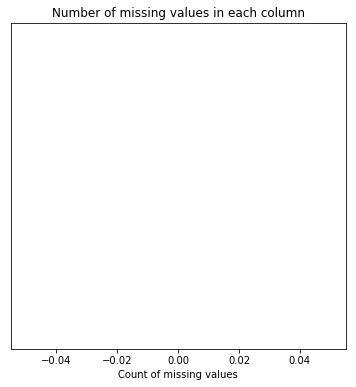

In [31]:
missing_df = all_data.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(6,6))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()


In [28]:
# cols_to_drop = missing_df.loc[missing_df['missing_ratio']>0.80]
# lst_var_to_drop = list(cols_to_drop.column_name.values)

# all_data.drop(lst_var_to_drop, axis=1, inplace=True)

In [32]:
all_data['garage_decade'] = all_data['garage_decade'].astype(str)
all_data.drop('GarageYrBlt', axis=1, inplace=True)

In [33]:
dtype_df = all_data.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]

In [34]:
dtype_df.groupby('Column Type').count().reset_index()

,Column Type,Count
0,int64,26
1,float64,10
2,object,43


In [35]:
# seperating out the categorical variables

cat_var = dtype_df[dtype_df['Column Type'] == 'object'].Count.values
cont_var = dtype_df[dtype_df['Column Type'] == 'float64'].Count.values

In [36]:
cat_var, cont_var

(array(['Alley', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
        'BsmtFinType2', 'BsmtQual', 'CentralAir', 'Condition1',
        'Condition2', 'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st',
        'Exterior2nd', 'Fence', 'FireplaceQu', 'Foundation', 'Functional',
        'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'Heating',
        'HeatingQC', 'HouseStyle', 'KitchenQual', 'LandContour',
        'LandSlope', 'LotConfig', 'LotShape', 'MSZoning', 'MasVnrType',
        'MiscFeature', 'Neighborhood', 'PavedDrive', 'PoolQC', 'RoofMatl',
        'RoofStyle', 'SaleCondition', 'SaleType', 'Street', 'garage_decade'], dtype=object),
 array(['BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath',
        'BsmtUnfSF', 'GarageArea', 'GarageCars', 'LotFrontage',
        'MasVnrArea', 'TotalBsmtSF'], dtype=object))

In [37]:
# Few of the above variables are really categorical but not continous, so transforming them into the same

#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)
all_data['YearBuilt'] = all_data['YearBuilt'].astype(str)
all_data['YearRemodAdd'] = all_data['YearRemodAdd'].astype(str)
all_data['YearRemodAdd'] = all_data['YearRemodAdd'].astype(str)


In [153]:
train_df['YrSold'] = train_df['YrSold'].astype(str)
train_df['MoSold'] = train_df['MoSold'].astype(str)
train_df['YearBuilt'] = train_df['YearBuilt'].astype(str)
train_df['YearRemodAdd'] = train_df['YearRemodAdd'].astype(str)
train_df['YearRemodAdd'] = train_df['YearRemodAdd'].astype(str)

### Missing Value Imputation

In [57]:
# categorical variables: to replace with the mode for that variable

for var in cat_var:
    all_data[var].fillna(all_data[var].mode()[0], inplace=True)
    
# to further improve the model, we would have to go through at variable level and impute values accrodingly

In [58]:
all_data[cont_var] = all_data[cont_var].fillna(all_data.mean().iloc[0])

#### Skew check in numerical features

In [38]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = train_df[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,24.451640
PoolArea,14.813135
LotArea,12.195142
3SsnPorch,10.293752
LowQualFinSF,9.002080
KitchenAbvGr,4.483784
BsmtFinSF2,4.250888
ScreenPorch,4.117977
BsmtHalfBath,4.099186
EnclosedPorch,3.086696


In [39]:
skewness = skewness[abs(skewness) > 0.75]

print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p

skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(train_df[feat], lam)

There are 32 skewed numerical features to Box Cox transform


In [82]:
for feat in skewed_features:
    #all_data[feat] += 1
    if (feat not in ['SalePrice', 'ln_SalePrice']) :
        test_df[feat] = boxcox1p(test_df[feat], lam)

In [ ]:
# In case of numerical varibles, capping the outliers to 95th-%tile.  
# Since linear regression is sensitive to outliers



In [26]:
# numerical variables: replacing with the mean value

# train_df_2['LotFrontage'].fillna((train_df_2['LotFrontage'].mean()), inplace=True)
# train_df_2['GarageYrBlt'].fillna((train_df_2['GarageYrBlt'].mean()), inplace=True)
# train_df_2['MasVnrArea'].fillna((train_df_2['MasVnrArea'].mean()), inplace=True)

In [40]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio
LotFrontage,58.855773
MasVnrArea,50.256937
WoodDeckSF,49.982871
GarageArea,49.982871
FullBath,49.982871


In [41]:
# creating the one hot encoded variables, and dropping the original variables

def get_dummies_ohe(df, varlst):
    df_mod = df.copy()
    for var in varlst:
        new_var_name_lst = []
        new_var_lst = pd.get_dummies(df[var])
        df_mod = df_mod.drop(var, axis=1)
        for elem in new_var_lst.columns:
            new_var_name_lst.append(var+'_'+str(elem))
        new_var_lst.columns = new_var_name_lst
        df_mod = df_mod.join(new_var_lst)
    return df_mod

In [42]:
all_data_2 = get_dummies_ohe(all_data, cat_var)

In [43]:
len(all_data_2.columns)

315

### Principal Component Analysis

In [44]:
from matplotlib.cm import register_cmap
from scipy import stats
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.preprocessing import StandardScaler


In [31]:
??sklearnPCA

In [45]:
train = all_data_2[:ntrain]
test = all_data_2[ntrain:]

In [46]:
y = train_df['ln_SalePrice']
X = train

In [47]:
X.columns

Index([u'1stFlrSF', u'2ndFlrSF', u'3SsnPorch', u'BedroomAbvGr', u'BsmtFinSF1',
       u'BsmtFinSF2', u'BsmtFullBath', u'BsmtHalfBath', u'BsmtUnfSF',
       u'EnclosedPorch',
       ...
       u'garage_decade_1930.0', u'garage_decade_1940.0',
       u'garage_decade_1950.0', u'garage_decade_1960.0',
       u'garage_decade_1970.0', u'garage_decade_1980.0',
       u'garage_decade_1990.0', u'garage_decade_2000.0',
       u'garage_decade_2010.0', u'garage_decade_2200.0'],
      dtype='object', length=315)

In [48]:
X = X.replace(np.nan, 0, regex=True)
X_std = StandardScaler().fit_transform(X)

In [49]:
test = test.replace(np.nan, 0, regex=True)
test_std = StandardScaler().fit_transform(test)

In [50]:
mean_vec = np.mean(X_std, axis=0)
cov_mat = (X_std - mean_vec).T.dot((X_std - mean_vec)) / (X_std.shape[0]-1)
print('Covariance matrix \n%s' %cov_mat)

Covariance matrix 
[[ 1.0006854  -0.33628594  0.05856703 ...,  0.20031801  0.06236991  0.        ]
 [-0.33628594  1.0006854  -0.02351383 ...,  0.02109444 -0.03936504  0.        ]
 [ 0.05856703 -0.02351383  1.0006854  ..., -0.01177708 -0.00580756  0.        ]
 ..., 
 [ 0.20031801  0.02109444 -0.01177708 ...,  1.0006854  -0.02784564  0.        ]
 [ 0.06236991 -0.03936504 -0.00580756 ..., -0.02784564  1.0006854   0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]


In [51]:
#Perform eigendecomposition on covariance matrix
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

In [52]:
print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[  1.04201047e-01 +0.00000000e+00j  -6.38002621e-02 +0.00000000e+00j
   -6.46731130e-02 +0.00000000e+00j ...,   4.35951464e-15 -4.73127399e-15j
    0.00000000e+00 +0.00000000e+00j   0.00000000e+00 +0.00000000e+00j]
 [  2.10315578e-02 +0.00000000e+00j   9.87391659e-02 +0.00000000e+00j
    8.78375652e-02 +0.00000000e+00j ...,   7.70185851e-15 -1.19021388e-14j
    0.00000000e+00 +0.00000000e+00j   0.00000000e+00 +0.00000000e+00j]
 [  1.19440303e-02 +0.00000000e+00j  -1.53256094e-02 +0.00000000e+00j
   -9.07930883e-03 +0.00000000e+00j ...,  -2.56601392e-16 +2.68877351e-16j
    0.00000000e+00 +0.00000000e+00j   0.00000000e+00 +0.00000000e+00j]
 ..., 
 [  1.48706589e-01 +0.00000000e+00j   1.35513262e-01 +0.00000000e+00j
   -1.83152833e-02 +0.00000000e+00j ...,  -4.34538705e-03 +5.28637693e-02j
    0.00000000e+00 +0.00000000e+00j   0.00000000e+00 +0.00000000e+00j]
 [  1.75911412e-02 +0.00000000e+00j   1.01242497e-02 +0.00000000e+00j
   -9.90880154e-03 +0.00000000e+00j ...,  -4.

In [53]:
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])


Eigenvalues in descending order:
19.5421395765
9.88888953377
8.16150987604
6.9635264829
6.50449148905
5.67829258605
4.64631121093
4.64490859122
3.82776916032
3.71532109789
3.64042241571
3.49813216583
3.28926008003
3.15760629061
3.03376729578
2.99126815288
2.88476237295
2.86086856264
2.74287412986
2.72673269983
2.67358550261
2.51606818011
2.50963267128
2.47603116286
2.38496915238
2.35241449233
2.32883840801
2.26286235557
2.22763044889
2.21843034098
2.17664076646
2.12570652029
2.11595761072
2.10188033964
2.09316093496
2.04459951371
2.00775415418
1.9616173061
1.95224957732
1.9381257941
1.92343847166
1.89632606131
1.86802259223
1.85384430912
1.7925056908
1.77918921337
1.75719186656
1.72286220625
1.69841195471
1.68050869028
1.63626522017
1.65285245745
1.66057759104
1.61819079802
1.60457421022
1.58992908588
1.57806494637
1.54342170722
1.52401705757
1.50625280513
1.50326661788
1.48650722649
1.4807415002
1.45696012288
1.43983071624
1.42736860576
1.41931978645
1.41089725407
1.3820004994
1.37460

In [54]:
pca = sklearnPCA(n_components=7)
pca.fit_transform(X)
print pca.explained_variance_ratio_


[ 0.73201363  0.14959234  0.02417695  0.01707909  0.01064955  0.00927899
  0.00710752]


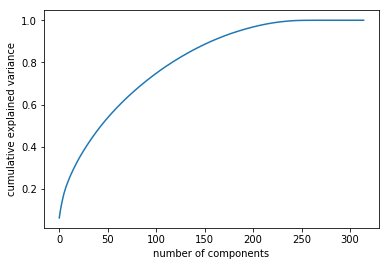

In [55]:
#Explained variance
pca = sklearnPCA().fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [56]:
eig_vecs.shape

(315, 315)

In [57]:
# planning to use top 5 components from PCA

eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
matrix_w = np.hstack((eig_pairs[0][1].reshape(315,1),
                      eig_pairs[1][1].reshape(315,1),
                      eig_pairs[2][1].reshape(315,1),
                      eig_pairs[3][1].reshape(315,1),
                      eig_pairs[4][1].reshape(315,1)))

In [58]:
pred_Y = X_std.dot(matrix_w)

In [59]:
new_test = test_std.dot(matrix_w)

In [60]:
X_pca_5 = pd.DataFrame(pred_Y, columns=['pca1','pca2','pca3','pca4','pca5'])

In [61]:
X_pca_5.head()

,pca1,pca2,pca3,pca4,pca5
0,(4.54302483424+0j),(1.86270888125+0j),(-0.0884681149397+0j),(0.346769589491+0j),(-2.16398686501+0j)
1,(0.216543424546+0j),(-3.1554263361+0j),(-0.23819482425+0j),(1.07968948006+0j),(-0.0802868723494+0j)
2,(5.40307804534+0j),(1.25152596101+0j),(-0.310016220627+0j),(0.117803487619+0j),(-0.780429479058+0j)
3,(-1.24992770703+0j),(-0.070611845047+0j),(2.04004242737+0j),(-2.97919825669+0j),(1.34462872138+0j)
4,(6.6454603864+0j),(1.01641824458+0j),(-0.436536148303+0j),(-0.526836345934+0j),(0.529661452778+0j)


In [62]:
X_pca_5.shape

(1460, 5)

### Comparing two models
* PCA based model
* Non-PCA based, only with one hot encoded variables

In [64]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

### Building Base Models

In [94]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_pca_5.values)
    rmse= np.sqrt(-cross_val_score(model, X_pca_5.values, y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)


In [213]:
# Lasso

lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

In [214]:
# ElasticNet

ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

In [215]:
# Kernel Ridge Regression

KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [93]:
# xgboost

model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

#### Models for the PCA data 

In [217]:
score = rmsle_cv(lasso)

print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.0065 (0.0004)



In [218]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.0065 (0.0004)



In [219]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.0060 (0.0004)



In [95]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

/Users/rachit/anaconda2/lib/python2.7/site-packages/xgboost/core.py:346: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(mat.reshape(mat.size), copy=False, dtype=np.float32)


Xgboost score: 0.1678 (0.0089)



#### Models for the original data

In [243]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train_df_2.values)
    rmse= np.sqrt(-cross_val_score(model, train_df_2.values, y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)


In [244]:
score = rmsle_cv(lasso)

print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.0006 (0.0000)



In [245]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.0006 (0.0000)



In [246]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.0121 (0.0007)



### Building a class to create stacked model

In [61]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [62]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        for model in self.models_:
            model.fit(X,y)
            
        return self

    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for model in self.models_])
        
        return np.mean(predictions, axis=1)

In [221]:
AveragedModel = AveragingModels(models = (ENet, model_xgb, KRR, lasso))

score = rmsle_cv(AveragedModel)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.0070 (0.0004)



In [69]:
AveragedModel = AveragingModels(models = (ENet, model_xgb, KRR, lasso))

score = rmsle_cv(AveragedModel)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.0200 (0.0014)



In [225]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [247]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

0.0126548340483


In [248]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = xgb_pred
sub.to_csv('submission.csv',index=False)

In [230]:
%ls

data_description.txt      submission.csv            train.csv
sample_submission.csv     test.csv                  train.csv.gz
sample_submission.csv.gz  test.csv.gz


In [231]:
%pwd

u'/Users/rachit/.kaggle/competitions/house-prices-advanced-regression-techniques'

In [249]:
sub.to_csv('/Users/rachit/Desktop/Tanuj/DataScientist/Kaggle/submission.csv', index=False)

### Lasso

In [65]:
y.shape, train.shape, test.shape

((1460,), (1460, 315), (1459, 315))

In [66]:
# X_train,X_test,y_train,y_test=train_test_split(train,y, test_size=0.2, random_state=31)
X_train,X_test,y_train,y_test=train_test_split(X_pca_5,y, test_size=0.2, random_state=31)

In [67]:
lasso = Lasso()
lasso.fit(X_train, y_train)
train_score=lasso.score(X_train, y_train)
test_score = lasso.score(X_test, y_test)
coeff_used = np.sum(lasso.coef_!=0)

print "training score: ", train_score
print "test score: ", test_score
print "number of features used: ", coeff_used

training score:  0.370432012775
test score:  0.337474730608
number of features used:  1


/Users/rachit/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/Users/rachit/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:32: ComplexWarning: Casting complex values to real discards the imaginary part
  return umr_sum(a, axis, dtype, out, keepdims)


In [68]:
X_train.shape, y_train.shape

((1168, 5), (1168,))

In [69]:
lasso001 = Lasso(alpha=0.01, max_iter=10e5)
lasso001.fit(X_train,y_train)
train_score001=lasso001.score(X_train,y_train)
test_score001=lasso001.score(X_test,y_test)
coeff_used001 = np.sum(lasso001.coef_!=0)
print "training score for alpha=0.01:", train_score001 
print "test score for alpha =0.01: ", test_score001
print "number of features used: for alpha =0.01:", coeff_used001

training score for alpha=0.01: 0.808592451524
test score for alpha =0.01:  0.791615897265
number of features used: for alpha =0.01: 4


In [70]:
lasso00001 = Lasso(alpha=0.0001, max_iter=10e5)
lasso00001.fit(X_train,y_train)
train_score00001=lasso00001.score(X_train,y_train)
test_score00001=lasso00001.score(X_test,y_test)
coeff_used00001 = np.sum(lasso00001.coef_!=0)
print "training score for alpha=0.0001:", train_score00001 
print "test score for alpha =0.0001: ", test_score00001
print "number of features used: for alpha =0.0001:", coeff_used00001

training score for alpha=0.0001: 0.808920423712
test score for alpha =0.0001:  0.792367448225
number of features used: for alpha =0.0001: 5


In [101]:
oot_test_score = lasso00001.predict(new_test)

In [102]:
oot_test_score.shape

(1459,)

In [106]:
final_test_score = np.expm1(oot_test_score.astype(np.float64))

sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = final_test_score
sub.to_csv('submission.csv',index=False)

/Users/rachit/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


In [108]:
sub.to_csv('/Users/rachit/Desktop/Tanuj/DataScientist/Kaggle/submission.csv', index=False)

In [107]:
final_test_score

array([ 134332.79352615,  164112.68928756,  196341.9947663 , ...,
        151649.24173949,  141806.62480828,  192087.49291605])

### Elastic Net

In [71]:
ENreg = ElasticNet(alpha=1, l1_ratio=0.5, normalize=False)
ENreg.fit(X_train,y_train)
train_score1=ENreg.score(X_train,y_train)
test_score1=ENreg.score(X_test,y_test)
# pred_cv = ENreg.predict(x_cv)

print "training score for alpha=1:", train_score1 
print "test score for alpha =1: ", test_score1


training score for alpha=1: 0.608344132708
test score for alpha =1:  0.569204160421


In [73]:
ENreg = ElasticNet(alpha=.0001, l1_ratio=0.5, normalize=False)
ENreg.fit(X_train,y_train)
train_score0001=ENreg.score(X_train,y_train)
test_score0001=ENreg.score(X_test,y_test)
# pred_cv = ENreg.predict(x_cv)

print "training score for alpha=.001:", train_score0001 
print "test score for alpha =.001: ", test_score0001


training score for alpha=.001: 0.808920449856
test score for alpha =.001:  0.792369287557


In [74]:
ENreg = ElasticNet(alpha=.01, l1_ratio=0.5, normalize=False)
ENreg.fit(X_train,y_train)
train_score01=ENreg.score(X_train,y_train)
test_score01=ENreg.score(X_test,y_test)
# pred_cv = ENreg.predict(x_cv)

print "training score for alpha=.01:", train_score01 
print "test score for alpha =.01: ", test_score01


training score for alpha=.01: 0.80882723398
test score for alpha =.01:  0.792071966289


In [78]:
ENreg = ElasticNet(alpha=.1, l1_ratio=0.9, normalize=False)
ENreg.fit(X_train,y_train)
train_score01=ENreg.score(X_train,y_train)
test_score01=ENreg.score(X_test,y_test)
# pred_cv = ENreg.predict(x_cv)

print "training score for alpha=.01:", train_score01 
print "test score for alpha =.01: ", test_score01


training score for alpha=.01: 0.79011815128
test score for alpha =.01:  0.77005278374


In [79]:
enet_oot_test_score = ENreg.predict(new_test)

In [80]:
final_test_score = np.expm1(enet_oot_test_score.astype(np.float64))

sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = final_test_score
sub.to_csv('/Users/rachit/Desktop/Tanuj/DataScientist/Kaggle/enet_submission_2.csv', index=False)

/Users/rachit/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


In [81]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [86]:
# model_xgb.fit(X_train,y_train)
# train_score_xgb=model_xgb.score(X_train.astype(np.float64),y_train)
# test_score_xgb=model_xgb.score(X_test.astype(np.float64),y_test)

# print "training score for xgb:", train_score_xgb 
# print "test score for alpha =.01: ", test_score_xgb
